In [1]:
import pandas as pd
pd.set_option('display.max_rows',5000)

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from datetime import datetime
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
import geopy as geo
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import ArcGIS

In [3]:
geolocator = ArcGIS(timeout=5)

def geocode_address(address):
    try_count = 0
    while try_count < 5:
        try:
            location = geolocator.geocode(address)
            return location
        except geo.exc.GeocoderUnavailable as e:
            try_count += 1
    return None

In [4]:
#lat = float(input('Latitude: '))
#long = float(input('Longitude: '))

In [5]:
#Rua N QNN 26 - Ceilândia, Brasília

In [6]:
address = input('Digite o endereço do estabelecimento: ')

In [7]:
address = geocode_address(address)

In [8]:
lat, long = address.latitude, address.longitude

In [9]:
#lat, long = -15.843596547989268, -48.101288048828565

In [10]:
from math import radians, cos, sin, asin, sqrt
# Implement the formula below
def distance_d(df, LaA=lat, LoA=long):
    # The function "radians" is found in the math module, It's also used to convert radians to degrees.  
    LoA = radians(LoA)  
    LoB = radians(df['num_longitude'])  
    LaA= radians(LaA)  
    LaB = radians(df['num_latitude']) 
    # The "Haversine formula" is used.
    D_Lo = LoB - LoA 
    D_La = LaB - LaA 
    P = sin(D_La / 2)**2 + cos(LaA) * cos(LaB) * sin(D_Lo / 2)**2  

    Q = 2 * asin(sqrt(P))   
        # The earth's radius in kilometers.
    R_km = 6371  
    # Then we'll compute the outcome.
    return(Q * R_km)

In [11]:
df = pd.read_csv('data/amostra_brasilia.csv')

In [12]:
df = df[((df['num_longitude'] >= long-0.1) & (df['num_longitude'] <= long+0.1)) & 
        ((df['num_latitude'] >= lat-0.1) & (df['num_latitude'] <= lat+0.1))]

In [13]:
df['distancia'] = df.apply(distance_d, axis=1)

In [14]:
lista_raios = [1, 2, 3]

--------------------------------------------------------
Total de estabelecimentos num raio de 1km: 8
Valor ticket médio: 77.88
Valor mediano dos tickets: 40.25
Valor médio dos tickets sem os 10% para cima e para baixo: 52.9
Número de transações: 209
Quantidade de clientes: 42




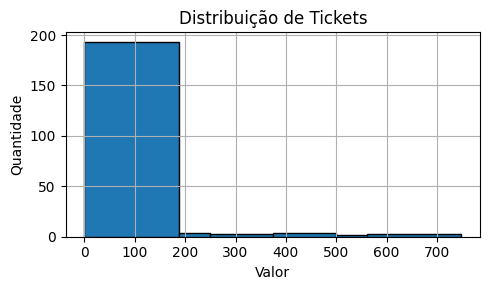



--------------------------------------------------------
Total de estabelecimentos num raio de 2km: 22
Valor ticket médio: 80.04
Valor mediano dos tickets: 38.5
Valor médio dos tickets sem os 10% para cima e para baixo: 50.16
Número de transações: 457
Quantidade de clientes: 86




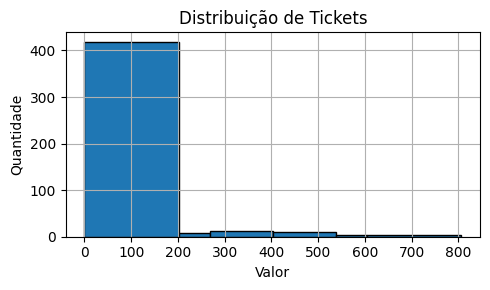



--------------------------------------------------------
Total de estabelecimentos num raio de 3km: 55
Valor ticket médio: 60.81
Valor mediano dos tickets: 30.23
Valor médio dos tickets sem os 10% para cima e para baixo: 40.7
Número de transações: 983
Quantidade de clientes: 174




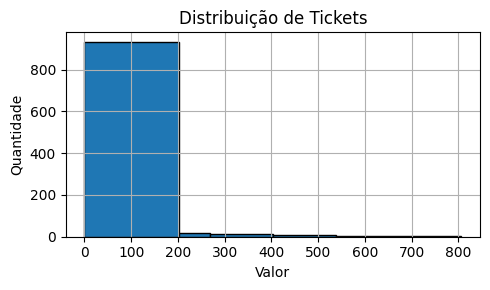

In [20]:
for i in lista_raios:
    df1 = df[df['distancia'] <= i]
    q = df1.val_transacao_consumo.quantile([0.1,0.9]).tolist()

    df1['dia_da_semana_num'] = df1.apply(lambda x: datetime.strftime(datetime.strptime(x['dat_transacao'], '%Y-%m-%dT%H:%M:%S.000Z'), '%w'), axis=1)
    df1['dia_da_semana'] = df1.apply(lambda x: datetime.strftime(datetime.strptime(x['dat_transacao'], '%Y-%m-%dT%H:%M:%S.000Z'), '%a'), axis=1)

    m = round(df1['val_transacao_consumo'].mean(),2)
    M = round(df1['val_transacao_consumo'].median(),2)
    m2 = round(df1[(df1['val_transacao_consumo'] > q[0]) & 
                   (df1['val_transacao_consumo'] < q[1])]
               ['val_transacao_consumo'].mean(),2)
    num = df1['num_cnpj'].drop_duplicates().shape[0]
    t = df1.shape[0]
    clientes = df1.srk_trabalhador_conta.drop_duplicates().shape[0]

    df1.groupby('dia_da_semana')[['val_transacao_consumo']].mean().reset_index()

    print('--------------------------------------------------------')
    print('Total de estabelecimentos num raio de', str(i) + 'km:', num)
    print('Valor ticket médio:', m)
    print('Valor mediano dos tickets:', M)
    print('Valor médio dos tickets sem os 10% para cima e para baixo:', m2)
    print('Número de transações:', t)
    print('Quantidade de clientes:', clientes)
    print('\n')

    # fig = plt.subplots(1, 1,
    #                         figsize =(5, 3),
    #                         tight_layout = True)
    # df1['hora'] = df1.apply(lambda x: datetime.strftime(datetime.strptime(x['dat_transacao'], '%Y-%m-%dT%H:%M:%S.000Z'), '%H'), axis=1)
    # df2 = df1.groupby(['dia_da_semana_num','dia_da_semana','hora'], as_index=False)['val_transacao_consumo'].mean().sort_values(['dia_da_semana_num'])
    # df3 = df2.pivot_table(index='dia_da_semana', columns='hora', values='val_transacao_consumo')
    # df3 = df3.reindex(['Sun','Mon','Tue','Wed','Thu','Fri','Sat'])
    # g = sns.heatmap(df3, annot=False, cmap='Greens')
    # g.set(xlabel='Hora',ylabel='Dia da semana')

    # df_agg = df1.groupby(['dia_da_semana','dia_da_semana_num'])[['val_transacao_consumo']].mean().reset_index().sort_values(['dia_da_semana_num'])


    # fig = plt.subplots(1, 1,
    #                         figsize =(5, 3),
    #                         tight_layout = True)

    # plt.title("Valor médio por dia da semana")
    # plt.xlabel('Dia da semana')
    # plt.ylabel('Valor médio')
    # plt.grid(True)
    # plt.plot(df_agg['dia_da_semana'], df_agg['val_transacao_consumo'], linestyle = "-")

    
    x = df1['val_transacao_consumo'].tolist()
    fig, axs = plt.subplots(1, 1,
                            figsize =(5, 3),
                            tight_layout = True)

    plt.title('Distribuição de Tickets')
    plt.xlabel('Valor')
    plt.ylabel('Quantidade')
    axs.hist(x, bins = [0, max(x)/4, max(x)/3, max(x)/2, 2*max(x)/3, 3*max(x)/4, max(x)],
             edgecolor='black', linewidth=1)
    plt.grid(True)
    plt.show()



    print('\n')